# Install prerequsits

In [9]:
!pip install tensorflow
!pip install numpy
!conda install pyarrow
!conda install sqlparse
!pip install ibmcloudsql
!pip install maxminddb-geolite2

import ibmcloudsql, sqlparse, sklearn.decomposition, scipy, matplotlib, time
import pandas as pd, numpy as np, matplotlib.pyplot as plt, networkx as nx, tensorflow as tf, seaborn as sn

from geolite2 import geolite2
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix

     |████████████████████████████████| 109.2MB 59.1MB/s eta 0:00:01
     |████████████████████████████████| 491kB 45.3MB/s eta 0:00:01
     |████████████████████████████████| 3.2MB 50.5MB/s eta 0:00:01
     |████████████████████████████████| 61kB 27.9MB/s eta 0:00:01
ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



# Prepare and Execute SQL Query (flow logs from COS to memory)

In [2]:
# instance CRN for the SQL Query instance - Look for the 'SQL Query app' under https://console.bluemix.net/dashboard/apps 
instnacecrn="crn:v1:bluemix:public:sql-query:us-south:a/01fedb4f3ff70b186d83cdb1e1df6879:3aa64b96-c4cc-4880-9ba0-efdd62bb838a::"
# API key for an IBM Cloud Object Storage bucket - under https://console.bluemix.net/iam/#/apikeys execute Manage->Security->Platform API Keys, click Create 
apikey="ZHdGyRMu9qTfy_dHeQNqnVxYmM_EtGwZtkGr2cE_sLtc"
# Query results destination - Follow the format as bellow
targeturl="cos://us-south/sql-3aa64b96-c4cc-4880-9ba0-efdd62bb838a/result/"    
# The SQL Query to perform - Follow the format as bellow (might change the */* to fit regex that match date/need/other)
sql = """
WITH flows as (SELECT explode(data) flow FROM cos://us-south/sa-seclogs-eran/IBM/netflow/vpc-region/vpc-guid/0/ingress/*/* STORED AS JSON)
SELECT flow.UUID, flow.Status, flow.Version, flow.Start, flow.Last, flow.Network.A AS src_ip, flow.Transport.A AS src_port, flow.Network.B AS dst_ip, flow.Transport.B AS dst_port, flow.Transport.Protocol, flow.Metric.ABPackets, flow.Metric.BAPackets, flow.Metric.ABBytes, flow.Metric.BABytes FROM flows"""

sqlClient = ibmcloudsql.SQLQuery(apikey, instnacecrn, client_info='SQL Query FlowLogs')
sqlClient.logon()
sql_with_target = sql + ' INTO {} STORED AS CSV'.format(targeturl)

print ("Start executing. this might take a while, so wait for it... To follow progress use:")
sqlClient.sql_ui_link()
result_df = sqlClient.run_sql(sql_with_target)
flowlogs_df = result_df.astype({'Start': 'datetime64[ms]','Last': 'datetime64[ms]',}).drop_duplicates()
# Artificially add an Action field, which gets an ACCEPTED value when dst_port=22. To be removed in the future
flowlogs_df['Action'] = np.where(flowlogs_df['dst_port']!=22.0, 'ACCEPTED', 'REJECTED')
flowlogs_df['Total_Packets'] = flowlogs_df['ABPackets'] + flowlogs_df['BAPackets']
flowlogs_df['Total_Bytes'] = flowlogs_df['ABBytes'] + flowlogs_df['BABytes']

print("Completed.")

Start executing. this might take a while, so wait for it... To follow progress use:
https://sql.ng.bluemix.net/sqlquery/?instance_crn=crn:v1:bluemix:public:sql-query:us-south:a/01fedb4f3ff70b186d83cdb1e1df6879:3aa64b96-c4cc-4880-9ba0-efdd62bb838a::
Completed.


In [3]:
from ibm_botocore.client import Config
import ibm_boto3

credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-5cead18f-7eb5-487d-93ad-d848f90a46e6',
    'IBM_API_KEY_ID': 'q2bzIZBPZ9Lkrz8uDBmr5l44Re56xWFkPlGLOcjuEzRF',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'flowlogsanalytics-donotdelete-pr-7vrxdvrveals1x',
    'FILE': 'ts.csv'
}

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

cos.download_file(Bucket=credentials['BUCKET'], Key='ts.csv', Filename='ts.csv')

ext_data = pd.read_csv('ts.csv')
ext_data = ext_data.rename(columns={"met_val": "Ext_data"})

In [42]:
import types

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_f391fb1040284eb4a7dcb9a54e69405b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='pnJqEzaqHNnEow7rwz_MeXU-OgB_rTWdpfoGYdIgJ04N',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_f391fb1040284eb4a7dcb9a54e69405b.get_object(Bucket='analytics-donotdelete-pr-hlnupjfgg1kqzy',Key='art.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

art_df = pd.read_csv(body)
art_df = art_df.astype({'Start': 'datetime64[ms]','Last': 'datetime64[ms]',})

,Unnamed: 0,UUID,Status,Version,Start,Last,src_ip,src_port,dst_ip,dst_port,Protocol,ABBytes,BABytes,ABPackets,BAPackets,Action,Total_Packets,Total_Bytes
0,0,5d095ce8-4545-4d64-a35c-515d0597b628,ENDED,4.2,2019-07-02 17:05:24,2019-07-02 17:05:25,10.132.196.39,1602,10.2.163.108,80,TCP,12000000,12000000,7937,7937,ACCEPTED,15874,24000000
1,1,b1694e21-8268-4564-aadf-b06f9bfccfa9,ENDED,4.2,2019-07-02 17:06:13,2019-07-02 17:06:14,54.210.206.49,2352,10.2.163.104,80,TCP,4720,4720,4,4,ACCEPTED,8,9440
2,2,ebb7eb4f-612b-4cb0-863c-e2df3863b497,ENDED,4.2,2019-07-02 17:15:07,2019-07-02 17:15:08,54.210.144.91,2352,10.2.163.106,80,TCP,7584,7584,6,6,ACCEPTED,12,15168
3,3,cc7823bd-7186-42f7-b802-cf2dbf595fc0,ENDED,4.2,2019-07-02 17:45:42,2019-07-02 17:45:43,52.90.83.149,2352,10.2.163.103,80,TCP,2688,2688,2,2,ACCEPTED,4,5376
4,4,cc719b32-009c-4114-9d2e-e09da4f4eca3,ENDED,4.2,2019-07-02 17:08:27,2019-07-02 17:08:28,10.110.215.196,1587,10.2.163.103,80,TCP,64000,64000,43,43,ACCEPTED,86,128000


# Utility Functions

In [328]:
def get_country(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['country']['names']['en'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

# Human-readable format
def number_format(num):
    magnitude = 0
    while num >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

# Scales arrays s.t the highest element size will be exactly max_size, and the ratio between every two element sizes will be 100 at most 
def scale(arr, max_size):
    while np.max(arr) > 100 * np.min(arr):
        arr = np.sqrt(arr)
    arr = arr * max_size / np.max(arr)
    return arr

# Returns the rows whereby the "Start" value is between the given dates
def date_filter(df, year1, month1, day1, year2, month2, day2):
    start_date = pd.to_datetime('%s-%s-%s' % (year1, month1, day1))
    end_date = pd.to_datetime('%s-%s-%s' % (year2, month2, day2))
    mask = (df['Start'] >= start_date) & (df['Start'] <= end_date)
    return df.loc[mask]

# Finds an index whereby the ratio between the sums of the sub-arrays it creates is maximized (returns the ratio and the index)
def calc_trend(df):
    high, index = 0, 0
    for i in range(1, len(df.index) - 1):
        before, after = np.mean(df.values[:i]), np.mean(df.values[i:])
        tmp = 100*(before-after)/before if before > 0 else 0
        if tmp > high:
            high, index = tmp, i
    return (high, df.index[index]) 

## Returns a dataset by demand (pandas df)
def get_data(kind):
    
    if kind == "Ext_data":
        return ext_data
    
    if kind == "Art_data":
        return art_df.set_index('Start')[['ABBytes']].resample('0.5Min').sum().fillna(0) 
    
    tot_df = flowlogs_df.set_index('Start')[['Total_Packets', 'Total_Bytes']].resample('1H').sum().fillna(0)  

    samples_num = len(tot_df.index)
    sin_arr1 = [np.sin(2*np.pi*x/24) * 0.1 * np.max(tot_df["Total_Packets"]) for x in range(samples_num)]
    sin_arr2 = [np.sin(2*np.pi*x/4) * 0.01 * np.max(tot_df["Total_Packets"]) for x in range(samples_num)]
    tot_df["Noisy_Packets"] = tot_df["Total_Packets"] + sin_arr1 + sin_arr2
    
    tot_df["flows"] = flowlogs_df.set_index('Start').resample('1H').size().replace(0, np.nan)
    tot_df["averageFlowPacket"] = tot_df["Total_Packets"] / tot_df["flows"]
    tot_df["averageFlowByte"] = tot_df["Total_Bytes"] / tot_df["flows"]
    tot_df["averagePacketSize"] = tot_df["Total_Bytes"] / tot_df["Total_Packets"]
    tot_df["flowBehavior"] = tot_df["flows"] / tot_df["averagePacketSize"]
    tot_df = tot_df.fillna(0)

    if kind == "Total_Packets":
        return tot_df.loc[:, ["Total_Packets"]]
    if kind == "Noisy_Packets":
        return tot_df.loc[:, ["Noisy_Packets"]] 
    if kind == "Att":
        return tot_df[["flows", "averageFlowPacket", "averageFlowByte", "averagePacketSize", "flowBehavior"]]

## Smooth a DF
def smooth_moving_average(data, window, stride=1):
    samples_num = int((len(data)  - window) / stride)
    indices = [i*stride + int(0.5*window) for i in range(samples_num)]
    return indices, [np.mean(data[i-int(0.5*window):i+int(0.5*window)]) for i in indices]

## Smooth a DF
def smooth_LP(df, coeff=4, thresh=0.1, stride=1):
    samples_num = int(len(df.index) / stride)
    indices = [df.index[i*stride] for i in range(samples_num)]
    smoothed_df = pd.DataFrame(index=indices, columns=df.columns)
    sample_indices = [i*stride for i in range(samples_num)]
    b, a = signal.butter(coeff, thresh)
    for c in df.columns:
        filtered = signal.lfilter(b, a, df[c].values)
        smoothed_df[c] = [filtered[i] for i in sample_indices]
    return smoothed_df

def conv2d(x, W, stride=1):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')

def conv2d_transpose(x, W, shape, stride=2):
    return tf.nn.conv2d_transpose(x, W, strides=stride, padding='SAME', output_shape=shape)

def max_pool(x, stride=2):
    return tf.nn.max_pool(x, ksize=[1, 1, stride, 1], strides=[1, 1, stride, 1], padding='SAME')

# min-max normalization
def normalize(data):
    normalized_data = data.copy()
    for c in normalized_data.columns:
        normalized_data[c] = ((data[c] - np.min(data[c])) / (np.max(data[c]) - np.min(data[c]))).fillna(0)
    return normalized_data

def standardize(data):
    standardized_data = data.copy()
    for c in standardized_data.columns:
        standardized_data[c] = ((data[c] - np.mean(data[c])) / (np.std(data[c]))).fillna(0)
    return standardized_data

# Given an array, finds indexes of extremely-high values
def find_anomalies_static(scores, thresh=3):
    threshold = np.mean(scores) + thresh * np.std(scores)
    return [i for (i, x) in enumerate(scores) if x > threshold]

# Given an array, finds indexes of extremely-high values
def find_anomalies_dynamic(scores, window, thresh=3):
    ind = []
    for i in range(len(scores) - window + 1):
        slot = scores[i:i+window]
        threshold = np.mean(slot) + thresh * np.std(slot)
        if slot[window-1] > threshold:
            ind.append(i+window-1)
    return ind

def anomaly_visualization(x, y, anomaly_indices, draw_trends=False):
    plt.figure(figsize=(20,5))
    if draw_trends == False:
        plt.plot(x, y, 'b')
        for i in anomaly_indices:
            plt.plot(x[i-1:i+1], y[i-1:i+1], 'r', linewidth=2)
    else:
        anomaly_indices = anomaly_indices + [0, len(x)-1]
        anomaly_indices.sort()        
        for i in range(1, len(anomaly_indices)):
            start, end = anomaly_indices[i-1], anomaly_indices[i]
            mid = int(0.5 * (start + end - 1))
            plt.plot(x[start:end], y[start:end])
            plt.annotate("Avg: %.2f" % np.mean(y[start:end]), xy=(x[mid], 0.1*np.max(y) + y[mid]), ha='center', bbox=dict(boxstyle="round4", fc="1."))
            if i < len(anomaly_indices) - 1:
                plt.plot(x[end-1:end+1], y[end-1:end+1], 'r', dashes=[3, 3])
    plt.xlabel('Time', fontsize=20), plt.ylabel('Packets', fontsize=20)
    plt.ylim(1.5 * np.min(y), 1.5 * np.max(y))
    plt.title("Signal Anomalies", fontsize=20)
    plt.show()
    
def find_changepoints(data, segsize, thresh):
    indices, cur_seg = [], []
    length = len(data)
    for i in range(length):
        cur_seg.append(data[i])
        x = np.array(range(len(cur_seg))).reshape((-1, 1))
        model = LinearRegression().fit(x, cur_seg)
        pred = model.predict(x)
        if mean_squared_error(pred, cur_seg) > thresh:
            indices.append(i)
            cur_seg = []
        elif len(cur_seg) > segsize:
            cur_seg.pop(0)
    return indices

def shingle(data, window):
    df_data, df_labels = pd.DataFrame(index=data.index[window:], columns=range(len(data.columns)*window)), pd.DataFrame(index=data.index[window:], columns=range(len(data.columns)))
    values = data.values.tolist()
    for i in range(len(df_data.index)):
        arr = []
        for k in range(window):
            arr = arr + values[i+k] 
        df_data.iloc[i] = arr
        df_labels.iloc[i] = data.iloc[window+i].values
    return df_data, df_labels

def get_stft(data, index, nperseg=25, noverlap=24):
    f, ts, Zxx = signal.stft(data, nperseg=nperseg, noverlap=noverlap)
    df = pd.DataFrame(index=[index[int(t)] for t in ts[:-(nperseg+1)]], columns=range(Zxx.shape[0]))
    for ind in range(len(df.index)):
        df.iloc[ind] = [np.abs(Zxx[i, ind]) for i in range(Zxx.shape[0])]
    plt.figure(figsize=(20, 4))
    plt.pcolormesh(ts, f, np.abs(Zxx))
    plt.title("Signal Spectrogram", fontsize=25)
    plt.xlabel('Time', fontsize=20), plt.ylabel('Frequency', fontsize=20)
    plt.show()
    return df

def plot_confusion_matrix(a, b):
    cm = confusion_matrix(a, b)
    plt.figure(figsize = (7,7))
    sn.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='Blues', fmt='g', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted', fontsize=16), plt.ylabel('Actual', fontsize=16)
    plt.show()

def cnn_regression(train_set, test_set, train_labels, test_labels, max_epochs=100, batch_size=64, activation=tf.nn.tanh, tolerance=0, initial=False):
    tf.reset_default_graph() 
    initializer = tf.contrib.layers.xavier_initializer()
    x = tf.placeholder(tf.float32, [None, sample_len])
    y = tf.placeholder(tf.float32, [None, label_len])
    x_reshaped = tf.reshape(x, [-1, 1, sample_len, 1])
    W1, W2, W3 = tf.Variable(initializer([1, 5, 1, 1])), tf.Variable(initializer([int(sample_len/2), int(sample_len/4)])), tf.Variable(initializer([int(sample_len/4), label_len]))
    b1, b2, b3 =  tf.Variable(initializer([1])), tf.Variable(initializer([int(sample_len/4)])), tf.Variable(initializer([label_len]))  
    x1 = activation(max_pool(conv2d(x_reshaped, W1, stride = 1) + b1))
    x1 = tf.reshape(x1, [-1, int(sample_len/2)])
    x2 = activation(tf.matmul(x1, W2) + b2)
    x3 = tf.matmul(x2, W3) + b3
    loss = tf.reduce_mean(tf.square(x3 - y))
    train = tf.train.RMSPropOptimizer(0.001).minimize(loss, var_list=[W1, W2, W3, b1, b2, b3])
    saver = tf.train.Saver()
    save_path='path'
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        if initial==True:
            sess.run(init)
            print("Model initialized.")
        else:
            saver.restore(sess, save_path=save_path)
            print("Model restored.")
        print("Start training...")
        test_loss, count = np.inf, 0
        for epoch in range(max_epochs):
            new_test_loss = loss.eval(feed_dict={x: test_set, y: test_labels})
            count = count+1 if new_test_loss > test_loss else 0
            if count > tolerance:
                print("Overfitting, early stopping...")
                break
            test_loss = new_test_loss
            for batch in range(int(train_size / batch_size)):
                sess.run(train, feed_dict={x: train_set.iloc[batch*batch_size:batch*batch_size+batch_size], y: train_labels.iloc[batch*batch_size:batch*batch_size+batch_size]})
            if epoch % 10 == 0:
                print("epoch: %g, train loss: %g" % (epoch, loss.eval(feed_dict={x: train_set, y: train_labels})))
        saver.save(sess, save_path=save_path)
        print("Training finished and saved. Calculating results...")
        pred = np.reshape([x3.eval(feed_dict={x: test_set.iloc[i:i+1], y: test_labels.iloc[i:i+1]}) for i in range(test_size)], len(test_labels.index))
        score = mean_squared_error(pred, np.reshape(test_labels.values, len(test_labels.index)))
        print("Done. Averaged test loss: %f" % score)
    return pred

# Analytics

# Daily Traffic

In [154]:
data_df = date_filter(flowlogs_df, 2019, 7, 1, 2019, 7, 3)
tot_df = data_df.set_index('Start')[['Total_Packets', 'Total_Bytes']].resample('1D').sum().fillna(0)
tot_df.plot.bar(rot=0, log=True, figsize=(20, 5))
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

# One-Way Flows

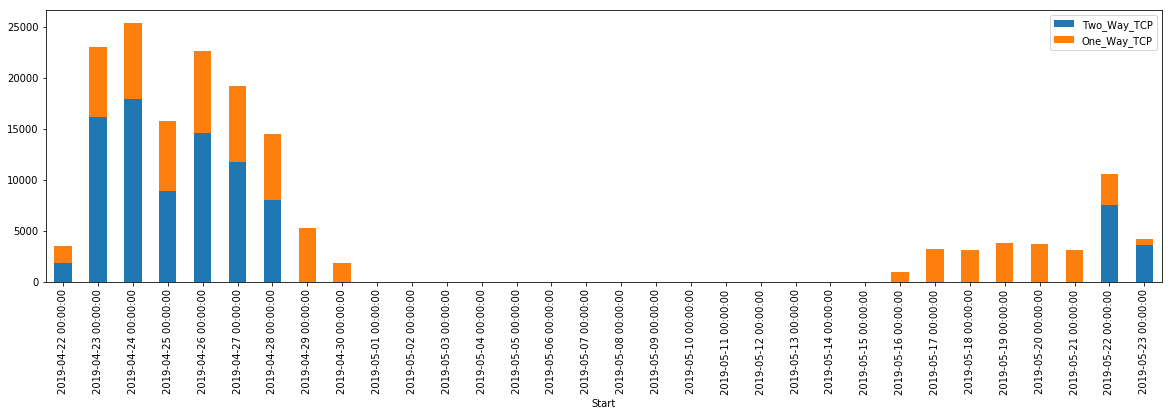

In [155]:
indices = flowlogs_df.set_index('Start').resample('1D').count().index
twowaytcp = flowlogs_df[(flowlogs_df['ABPackets'] != 0) & (flowlogs_df['BAPackets'] != 0) & (flowlogs_df['Protocol'] == "TCP")].set_index('Start').iloc[:, 0].resample('1D').count().fillna(0).values
onewaytcp = flowlogs_df[((flowlogs_df['ABPackets'] == 0) | (flowlogs_df['BAPackets'] == 0)) & (flowlogs_df['Protocol'] == "TCP")].set_index('Start').iloc[:, 0].resample('1D').count().fillna(0).values
tcp_df = pd.DataFrame(index=indices, columns=["Two_Way_TCP", "One_Way_TCP"])
tcp_df["Two_Way_TCP"] = twowaytcp
tcp_df["One_Way_TCP"] = onewaytcp
tcp_df.plot.bar( stacked=True, figsize=(20, 5))
plt.show()

# Hotspots

The most active instance is 169.60.53.46, which sends and receives an averaged amount of 9.80K packets per day


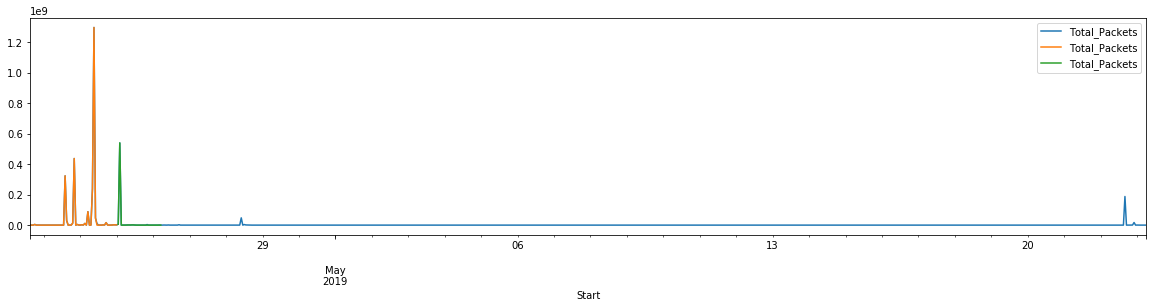

In [66]:
# Select number of hotspots to detect
hotspots_num = 3
src_df = flowlogs_df.groupby(['src_ip']).agg({'Total_Packets':'sum'})
dst_df = flowlogs_df.groupby(['dst_ip']).agg({'Total_Packets':'sum'})
tot_df = src_df.append(dst_df)
tot_df = tot_df.groupby(tot_df.index).agg({'Total_Packets':'sum'}).sort_values(by=['Total_Packets'], ascending=False).head(hotspots_num)

print("The most active instance is %s, which sends and receives an averaged amount of %s packets per day" % (tot_df.index[0], number_format(tot_df["Total_Packets"].values[0] / len(flowlogs_df.index))))

plt.figure(figsize=(20, 4))

for instance in tot_df.index:
    instance_df = flowlogs_df[(flowlogs_df['src_ip'] == instance) | (flowlogs_df['dst_ip'] == instance)].set_index('Start')["Total_Packets"].resample('1H').sum().fillna(0).to_frame("Total_Packets")["Total_Packets"].plot()
plt.legend()
plt.show()

# Rejection Percentage by Source

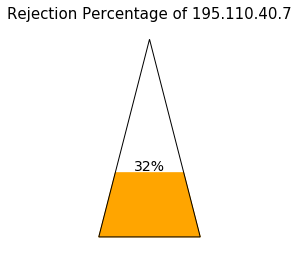

In [67]:
## Insert an IP address 
ip = "195.110.40.7"
src_df = flowlogs_df.loc[flowlogs_df['src_ip'] == ip]
rejection_ratio = 100 * len(src_df.loc[src_df['Action'] == "REJECTED"].index) / len(src_df.index)
rejection_str = str(int(rejection_ratio)) + "%" 

pts1 = [(-1, 0), (1, 0), (0, 100)]
pts2 = [(-1, 0), (-1+rejection_ratio*0.01, rejection_ratio), (1-rejection_ratio*0.01, rejection_ratio), (1, 0)]
plt.figure(figsize=(2,4))
ax = plt.subplot(111)
triangle = plt.Polygon(pts1, fill=False, edgecolor='black')
percentage = plt.Polygon(pts2, fill=True, edgecolor='orange', facecolor='orange')
ax.add_patch(percentage)
ax.add_patch(triangle)

ax.plot()
ax.axis('off')
plt.title("Rejection Percentage of %s" % ip, y=1.02, fontdict={'fontsize': 15})
plt.annotate(rejection_str, xy=(0,rejection_ratio+1), ha="center", size=14)

plt.show()

## Rejection Percentage Histogram

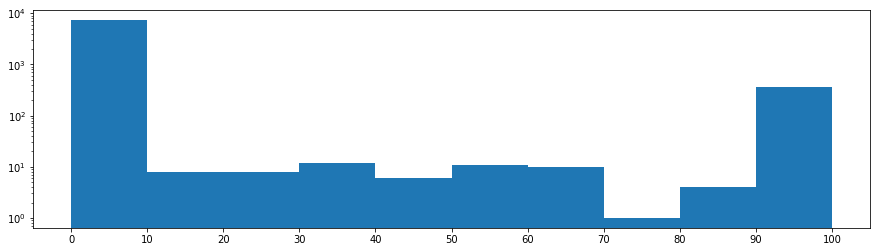

In [68]:
tot_df = flowlogs_df.groupby(['src_ip']).size().to_frame('size')
rejected_df = flowlogs_df.loc[flowlogs_df['Action']=='REJECTED'].groupby(['src_ip']).size().to_frame('size')
tot_df["Ratio"] = (rejected_df["size"] / tot_df["size"]).fillna(0)*100
plt.figure(figsize=(15,4))
plt.hist(tot_df["Ratio"], log=True)
plt.xticks(range(0, 101, 10))
plt.show()

# Total Traffic - Port Distribution

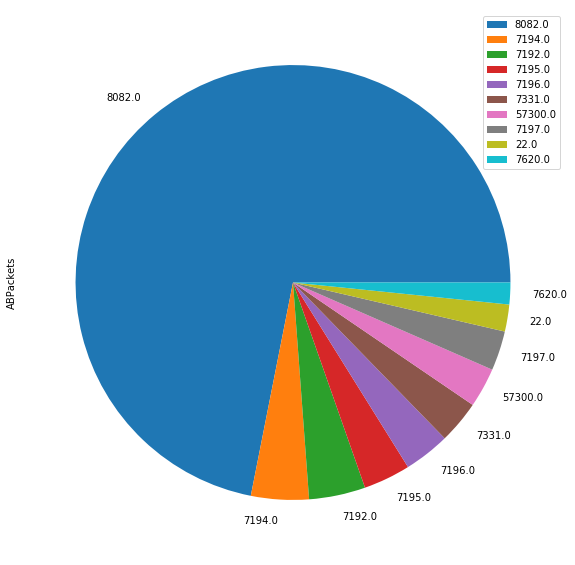

In [69]:
portsAB_df = flowlogs_df.groupby(['dst_port']).agg({'ABPackets':'sum'}).nlargest(10, 'ABPackets')
portsBA_df = flowlogs_df.groupby(['src_port']).agg({'BAPackets':'sum'}).nlargest(10, 'BAPackets').rename(columns={"BAPackets": "ABPackets"})
ports_df = portsAB_df.append(portsBA_df)
res_df = ports_df.groupby(ports_df.index).agg({'ABPackets':'sum'}).nlargest(10, 'ABPackets')
res_df.plot(kind='pie', figsize=(10,10), subplots='True')
plt.show()

# Top Source-Destination Locations of Traffic, by Flows

In [70]:
print("This might take a while, please wait...")
geo = geolite2.reader()
flowlogs_df['src_country'] = flowlogs_df['src_ip'].apply(get_country)
flowlogs_df['dst_country'] = flowlogs_df['dst_ip'].apply(get_country)
geolite2.close()
flowlogs_df.groupby(['src_country', 'dst_country']).size().to_frame('flows_num').nlargest(10, 'flows_num').reset_index()

This might take a while, please wait...


KeyboardInterrupt: 

# Inbound/Outbound Packets by Source

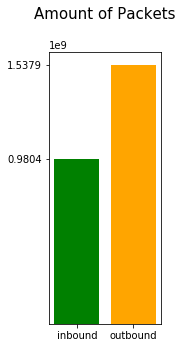

In [71]:
## Insert an IP address 
ip = "5.102.239.42"
src_df = flowlogs_df.loc[flowlogs_df['src_ip'] == ip]
dst_df = flowlogs_df.loc[flowlogs_df['dst_ip'] == ip]

inbound = np.nan_to_num(src_df["BAPackets"].sum()) + np.nan_to_num(dst_df["ABPackets"].sum())
outbound = np.nan_to_num(src_df["ABPackets"].sum()) + np.nan_to_num(dst_df["BAPackets"].sum())

plt.figure(figsize=(2,5))
plt.xticks([1, 2], ["inbound", "outbound"]), plt.yticks([inbound, outbound])
plt.bar([1], [inbound], color='green'), plt.bar([2], [outbound], color='orange')
plt.title("Amount of Packets", y=1.1, fontdict={'fontsize': 15})
plt.show()

# Average Packet Size

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


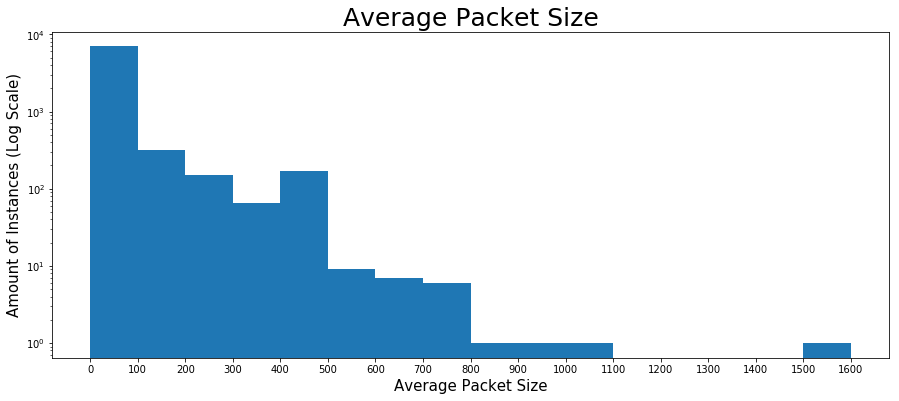

In [72]:
inverted_df = flowlogs_df.rename(columns={"BAPackets":"ABPackets", "ABPackets":"BAPackets", "BABytes":"ABBytes", "ABBytes":"BABytes"}).append(flowlogs_df).groupby(['src_ip']).agg({'ABPackets':'sum', 'ABBytes':'sum'})
inverted_df["avg_size"] = inverted_df["ABBytes"] / inverted_df["ABPackets"]
plt.figure(figsize=(15,6))
bins = [100 * i for i in range(int(2 + 0.01*np.max(inverted_df["avg_size"].values)))]
plt.hist(inverted_df["avg_size"], log=True, bins=bins)
plt.xticks([bin for bin in bins])
plt.title("Average Packet Size", size=25)
plt.xlabel('Average Packet Size', size=15), plt.ylabel('Amount of Instances (Log Scale)', size=15)
plt.show()

# Top-N Talking Pairs, by Chosen Metric

The top talking pair is (5.102.239.42, 169.60.53.46),
While 61.07% of the traffic goes from 5.102.239.42 to 169.60.53.46





/opt/conda/envs/Python36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


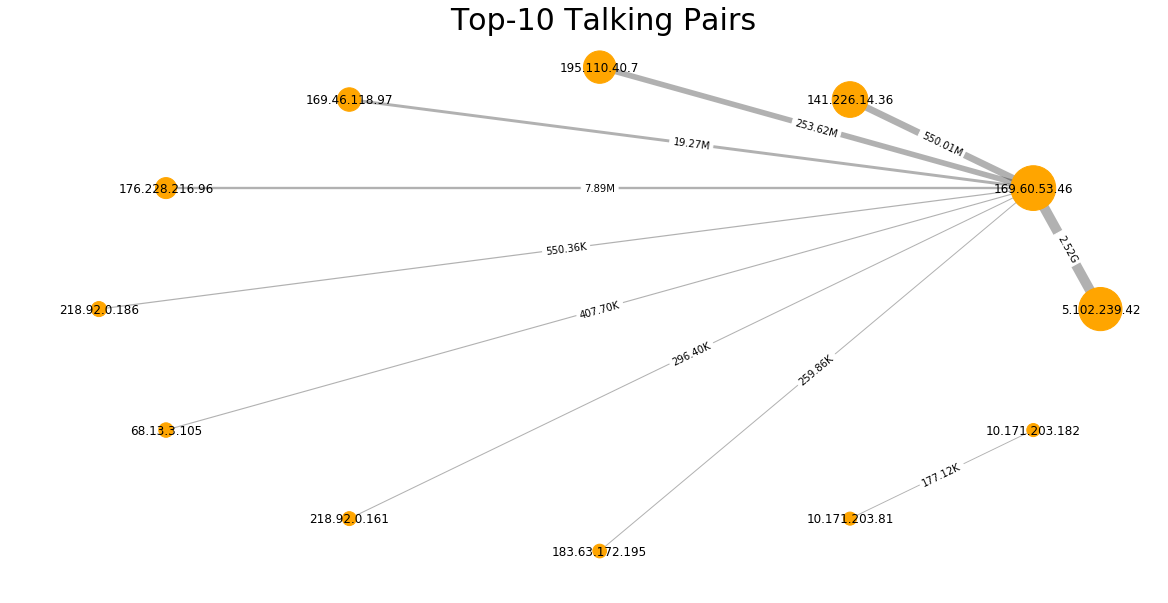

In [73]:
# Insert amout of pairs
N = 10
AB_df = flowlogs_df.loc[flowlogs_df["src_ip"] > flowlogs_df["dst_ip"]]
BA_df = flowlogs_df.loc[flowlogs_df["dst_ip"] > flowlogs_df["src_ip"]].rename(columns={"src_ip":"dst_ip", "dst_ip":"src_ip", "ABPackets":"BAPackets", "BAPackets":"ABPackets"})
ordered_df = AB_df.append(BA_df)
    
res_df = ordered_df.groupby(['src_ip', 'dst_ip']).agg({"Total_Packets":'sum', "ABPackets":'sum', "BAPackets":'sum'}).nlargest(N, 'Total_Packets').sort_values(by=["Total_Packets"], ascending=False).reset_index()

ip1, ip2, stream1, stream2 = res_df.iloc[0][["src_ip", "dst_ip", "ABPackets", "BAPackets"]]
A, B, AB, BA = (ip1, ip2, stream1, stream2) if stream1 > stream2 else (ip2, ip1, stream2, stream1)

print("The top talking pair is (%s, %s)," % (A,  B))
print("While %.2f%% of the traffic goes from %s to %s\n\n\n" % (100*AB/(AB + BA), A,  B))

# Plot Graph

plt.figure(figsize=(20,10))

edges = [(res_df['src_ip'].iloc[i], res_df['dst_ip'].iloc[i], {'weight': res_df['Total_Packets'].iloc[i]}) for i in range(len(res_df.index))]

G = nx.OrderedGraph()
G.add_edges_from(edges)

# positions for all nodes
pos = nx.circular_layout(G) 

# labels
nx.draw_networkx_labels(G, pos)

# edge widths
widths = scale(res_df['Total_Packets'].values, 10)

# edges
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.3)

# node sizes
sizes = scale([elem[1] for elem in G.degree(weight='weight')], 2000)

nx.draw_networkx_nodes(G, pos, node_color = 'orange', node_size = sizes)

# weights
labels = nx.get_edge_attributes(G, 'weight')
for key, value in labels.items():
    labels[key] = number_format(value)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.axis('off')
plt.title('Top-%s Talking Pairs' % N, fontsize=30)
plt.show()

# Alerts

In [24]:
# Select threshold of flows and duration (by hours)
threshold = 13000
duration = 1
sorted_df = flowlogs_df.sort_values(by=['dst_ip', 'Start'])
shifted_df = sorted_df.shift(-threshold)
sorted_df['Diff'] = (shifted_df['Start'] - sorted_df['Start']).astype('timedelta64[h]')
alerts_df = sorted_df.loc[(sorted_df['Diff'] < duration) & (shifted_df['dst_ip'] == sorted_df["dst_ip"])]
alerts_df[['Start', 'dst_ip']].reset_index(drop=True).head(10)

,Start,dst_ip
0,2019-04-24 08:26:59.093,169.60.53.46
1,2019-04-24 08:26:59.093,169.60.53.46
2,2019-04-24 08:27:06.653,169.60.53.46
3,2019-04-24 08:27:06.653,169.60.53.46
4,2019-04-24 08:27:16.232,169.60.53.46
5,2019-04-24 08:27:16.232,169.60.53.46
6,2019-04-24 08:27:36.515,169.60.53.46
7,2019-04-24 08:27:36.515,169.60.53.46
8,2019-04-24 08:27:54.414,169.60.53.46
9,2019-04-24 08:28:52.350,169.60.53.46


## Most Significant Trend of a Hotspot

In [74]:
hotspots_num = 5
src_df = flowlogs_df.groupby(['src_ip']).agg({'Total_Packets':'sum'})
dst_df = flowlogs_df.groupby(['dst_ip']).agg({'Total_Packets':'sum'})
tot_df = src_df.append(dst_df)
tot_df = tot_df.groupby(tot_df.index).agg({'Total_Packets':'sum'}).sort_values(by=['Total_Packets'], ascending=False).head(hotspots_num)

high, date, ip = 0, 0, 0
for instance in tot_df.index:
    instance_score, i = calc_trend(flowlogs_df[(flowlogs_df['src_ip'] == instance) | (flowlogs_df['dst_ip'] == instance)].set_index('Start')["Total_Packets"].resample('1D').sum().fillna(0))
    if instance_score > high:
        ip, high, date = instance, instance_score, i
 
print("IP %s has lowered his activity by %.2f%% since %s" % (ip, high, date.strftime('%Y-%m-%d')))

IP 169.60.53.46 has lowered his activity by 98.76% since 2019-04-26


# Anomaly Detection

## Autoencoder

In [538]:
def conv_autoencoder(train_set, test_set, max_epochs=100, batch_size=64, activation=tf.nn.tanh, tolerance=0, initial=False):
    tf.reset_default_graph() 
    initializer = tf.contrib.layers.xavier_initializer()
    
    x = tf.placeholder(tf.float32, [None, sample_len])
    x_reshaped = tf.reshape(x, [-1, 1, sample_len, 1])
    W1, W2, W3, W4, W5 = tf.Variable(initializer([1, 5, 1, 1])), tf.Variable(initializer([1, 5, 1, 1])),  tf.Variable(initializer([1, 5, 1, 1])), tf.Variable(initializer([1, 5, 1, 1])), tf.Variable(initializer([1, 7, 1, 1]))
    b1, b2, b3, b4, b5 =  tf.Variable(initializer([1])), tf.Variable(initializer([1])), tf.Variable(initializer([1])), tf.Variable(initializer([1])), tf.Variable(initializer([1]))
    x1 = activation(conv2d(x_reshaped, W1, stride = 2) + b1)
    x2 = conv2d(x1, W2, stride = 1) + b2
    x3 = conv2d_transpose(x2, W3, shape=tf.shape(x_reshaped)) + b3
    x4 = activation(conv2d(x3, W4, stride = 1) + b4)
    x5 = conv2d(x4, W5, stride = 1) + b5
    x5 = tf.reshape(x5, [-1, sample_len])
    loss = tf.reduce_mean(tf.square(x5 - x))
    train = tf.train.RMSPropOptimizer(0.001).minimize(loss, var_list=[W1, W2, W3, W4, W5, b1, b2, b3, b4, b5])
    saver = tf.train.Saver()
    save_path='path'
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        if initial==True:
            sess.run(init)
            print("Model initialized.")
        else:
            saver.restore(sess, save_path=save_path)
            print("Model restored.")
        print("Start training...")
        test_loss, count = np.inf, 0
        for epoch in range(max_epochs):
            new_test_loss = loss.eval(feed_dict={x: test_set})
            count = count+1 if new_test_loss > test_loss else 0
            if count > tolerance:
                print("Overfitting, early stopping...")
                break
            test_loss = new_test_loss
            for batch in range(int(train_size / batch_size)):
                sess.run(train, feed_dict={x: train_set.iloc[batch*batch_size:batch*batch_size+batch_size]})
            if epoch % 10 == 0:
                print("epoch: %g, train loss: %g" % (epoch, loss.eval(feed_dict={x: train_set})))
        saver.save(sess, save_path=save_path)
        print("Training finished and saved. Calculating results...")
        pred = [x5.eval(feed_dict={x: test_set.iloc[i:i+1]}) for i in range(len(test_set.index))]
        score = mean_squared_error(np.reshape(pred, [len(test_set.index), sample_len]), np.reshape(test_set.values, [len(test_set.index), sample_len]))
        print("Done. Averaged test loss: %f" % score)
        encoded = np.reshape([x2.eval(feed_dict={x: test_set.iloc[i:i+1]}) for i in range(len(test_set.index))], [len(test_set.index), int(sample_len / 2)])
    return pd.DataFrame(data=encoded, index=test_set.index)

## Preapare Time-Series Data

In [544]:
# "data_name" is the name of the chosen dataset
data_name = "Art_data"
# "data_df" consists of one column, which is the original signal we try to predict
data_df = get_data(data_name).iloc[0:2000]

split_index = int(0.8*len(data_df.index))
train_df, test_df = standardize(data_df[:split_index]), standardize(data_df[split_index:])
train_set, train_labels = shingle(train_df, window=64)
test_set, test_labels = shingle(test_df, window=64)

train_size, test_size = len(train_set.index), len(test_set.index)
sample_len, label_len = len(train_set.columns), len(train_labels.columns)

In [545]:
training_phase = conv_autoencoder(train_set, test_set, max_epochs=200, batch_size=64, initial=True, tolerance=25)

Model initialized.
Start training...
epoch: 0, train loss: 1.22287
epoch: 10, train loss: 0.820133
epoch: 20, train loss: 0.767705
epoch: 30, train loss: 0.707699
epoch: 40, train loss: 0.659183
epoch: 50, train loss: 0.618237
epoch: 60, train loss: 0.577093
epoch: 70, train loss: 0.543322
epoch: 80, train loss: 0.518047
epoch: 90, train loss: 0.498768
epoch: 100, train loss: 0.483716
epoch: 110, train loss: 0.471857
epoch: 120, train loss: 0.462111
epoch: 130, train loss: 0.452852
epoch: 140, train loss: 0.442627
epoch: 150, train loss: 0.435366
epoch: 160, train loss: 0.430184
Overfitting, early stopping...
Training finished and saved. Calculating results...
Done. Averaged test loss: 0.170668


In [546]:
train_set = conv_autoencoder(train_set, train_set, max_epochs=0, batch_size=64, initial=False, tolerance=5)
test_set = conv_autoencoder(test_set, test_set, max_epochs=0, batch_size=64, initial=False, tolerance=5)

Model restored.
Start training...
Training finished and saved. Calculating results...
Done. Averaged test loss: 0.428848
Model restored.
Start training...
Training finished and saved. Calculating results...
Done. Averaged test loss: 0.170668


## 1D Time-Series Anomaly Visualization

In [547]:
sample_len = len(train_set.columns)
pred = cnn_regression(train_set, test_set, train_labels, test_labels, max_epochs=500, batch_size=64, initial=True, tolerance=10)

Model initialized.
Start training...
epoch: 0, train loss: 1.34902
epoch: 10, train loss: 1.03812
epoch: 20, train loss: 1.0355
epoch: 30, train loss: 1.03343
epoch: 40, train loss: 1.03083
epoch: 50, train loss: 1.02541
epoch: 60, train loss: 1.00933
epoch: 70, train loss: 0.971581
epoch: 80, train loss: 0.942673
epoch: 90, train loss: 0.93005
epoch: 100, train loss: 0.920526
epoch: 110, train loss: 0.912821
epoch: 120, train loss: 0.906469
epoch: 130, train loss: 0.901039
epoch: 140, train loss: 0.896179
Overfitting, early stopping...
Training finished and saved. Calculating results...
Done. Averaged test loss: 0.378537


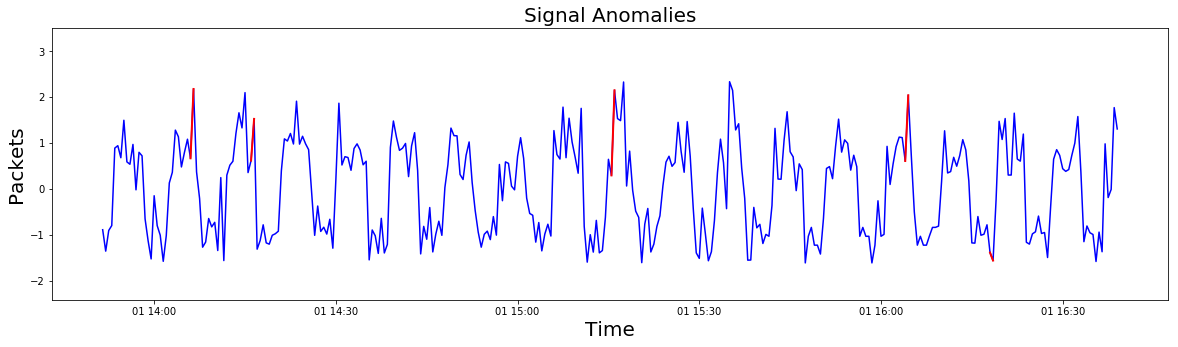

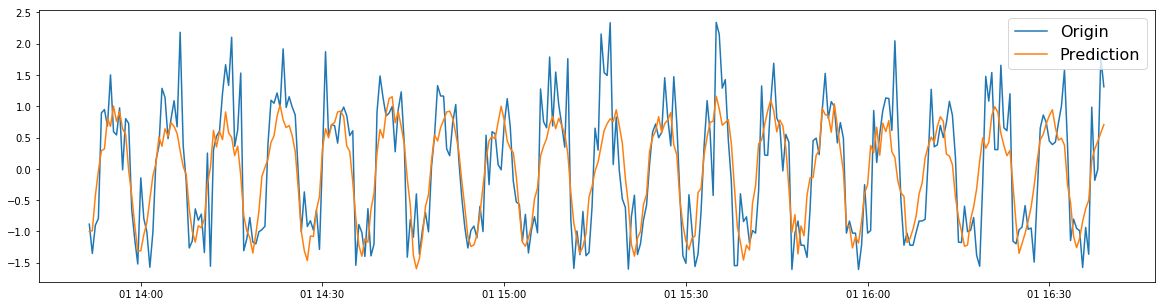

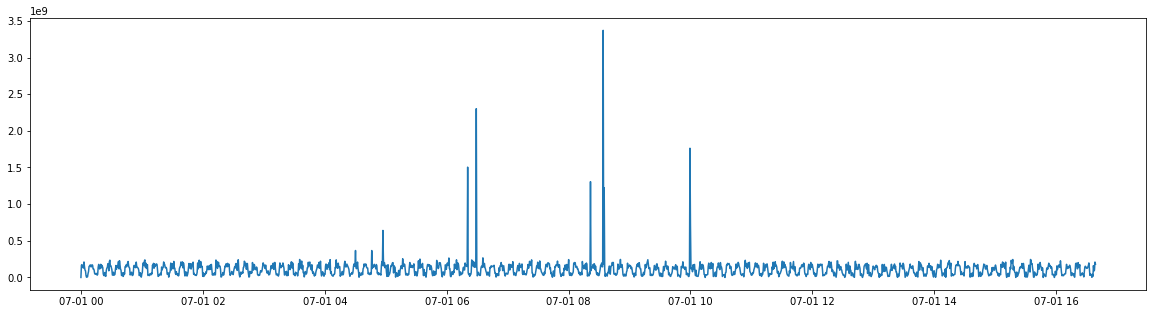

In [543]:
actual = np.reshape(test_labels.values, len(test_labels.index))
scores = np.abs(actual - pred)
anomalies = find_anomalies_static(scores, thresh=3)

xaxis = test_set.index.to_pydatetime() if data_name not in ["Ext_data", "Art_data"] else test_set.index.values
yaxis = [test_df.loc[x] for x in xaxis]


anomaly_visualization(xaxis, yaxis, anomalies, draw_trends=False)

plt.figure(figsize=(20, 5))
plt.plot(xaxis, yaxis, xaxis, pred)
plt.legend(["Origin", "Prediction"], prop={'size': 16})

plt.figure(figsize=(20, 5))
plt.plot(data_df)

plt.show()

## Confusion Matrix

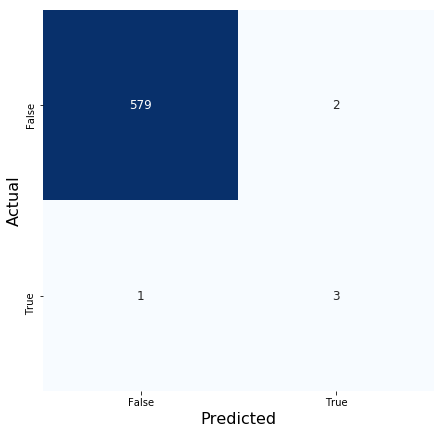

In [437]:
my, their = [0] * test_size, [0] * test_size

anomalies_x = [xaxis[i] for i in anomalies]
for i in anomalies_x:
    my[i-xaxis[0]] = 1
    
anom_df = ext_data.iloc[test_set.index.values]
anom_df = anom_df[anom_df["is_anom"] == True]
for i in anom_df.index.values:
    their[i-xaxis[0]] = 1

plot_confusion_matrix(their, my)

## PCA

In [539]:
data_name = "Att"
data = normalize(get_data(data_name))

train_size, test_size = int(0.8 * len(data)), int(0.2 * len(data))
train_set, test_set = data.iloc[test_size:].values, data.iloc[:test_size].values

pca = sklearn.decomposition.PCA()
pca.fit(train_set)

nComp = 4
Xhat = np.dot(pca.transform(test_set)[:,:nComp], pca.components_[:nComp,:]) + np.mean(test_set, axis=0)

scores = [np.square(test_set[i] - Xhat[i,]) for i in range(test_size)]
print('loss: %.3f' % np.mean(scores))

loss: 0.004


# Towards Trend Analysis

## Seasonality with Autocorrelation

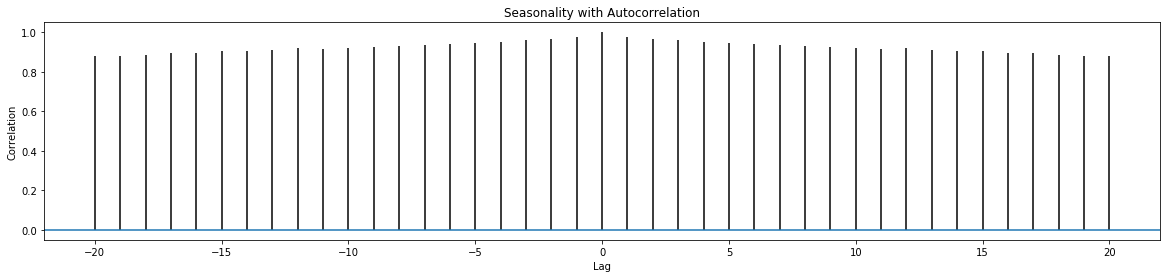

In [23]:
data = data_df["Ext_data"].values[-2000:]

plt.figure(figsize=(20,4))
plt.acorr(data, maxlags=20)
plt.title("Seasonality with Autocorrelation")
plt.xlabel("Lag"), plt.ylabel("Correlation")
plt.show()

## Seasonality with FFT

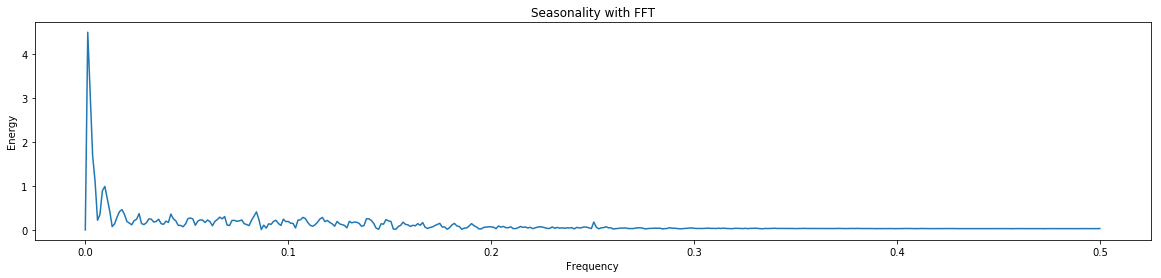

This signal has periodicity of ['92.2'] samples


In [40]:
window, stride = 5, 3

data_name = "Ext_data"
data_df = normalize(get_data(data_name))
data = smooth_LP(data_df.iloc[0:2500], stride = stride, thresh = 0.1)[data_name]

length = len(data)
m = np.mean(data)
data = [x - m for x in data]
freq = np.linspace(0, 0.5, int(length/2))
energy = np.abs(scipy.fftpack.fft(data))[0:int(length/2)]
plt.figure(figsize=(20,4))
plt.plot(freq, energy)
plt.title("Seasonality with FFT")
plt.xlabel("Frequency"), plt.ylabel("Energy")
plt.show()

dom_freq = freq[find_anomalies(energy, 2)]
cycles = list(set(["%.1f" % (1 / f) for f in dom_freq if f > 0.01]))
print("This signal has periodicity of %s samples" % cycles)